In [76]:
import numpy as np
import pandas as pd
from collections import Counter
import bz2
import re
import os
import gc
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import time
import warnings


In [3]:
train_file = bz2.BZ2File('/content/amazonreviews/train.ft.txt.bz2')
test_file = bz2.BZ2File('/content/amazonreviews/test.ft.txt.bz2')

In [4]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [5]:
# clean the older variables
del train_file, test_file
gc.collect()

0

## Data Preparation and Cleaning

- Lowercasing
- Tokenization
- Stemming and Lemmatization
- Removing Stopwords
- Removing Punctuations
- Removing Digits
- Removing Url’s


> ### Convert from raw binary strings to strings that can be parsed

In [6]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [7]:
print(type(train_file_lines), type(test_file_lines), "\n")

print("Train Data Volume:", len(train_file_lines), "\n")
print("Test Data Volume:", len(test_file_lines), "\n\n")

print("Demo: ", "\n")
for x in train_file_lines[:2]:
    print(x, "\n")

<class 'list'> <class 'list'> 

Train Data Volume: 3600000 

Test Data Volume: 400000 


Demo:  

__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
 

__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, t

### Extracting Labels from the data
`0 -> __label__1 -> 1/2 star rating`  
`1 -> __label__2 -> 4/5 star rating`

In [8]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]

In [10]:
train_labels[0]

1

Counter({1: 1800000, 0: 1800000})


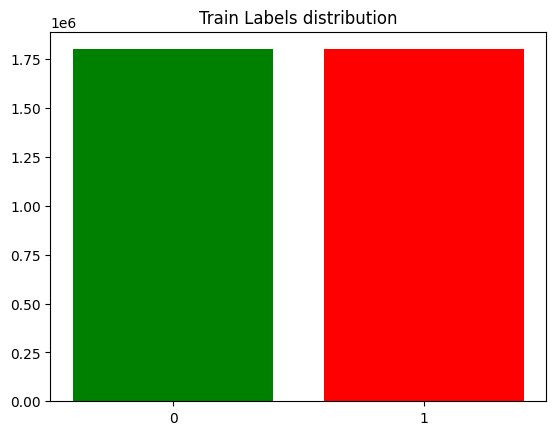

In [11]:
train_label_counts = Counter(train_labels)
print(train_label_counts)
plt.bar(train_label_counts.keys(),train_label_counts.values(),color=['red','green'])
plt.xticks([0,1])
plt.title('Train Labels distribution')
plt.show()

Counter({1: 200000, 0: 200000})


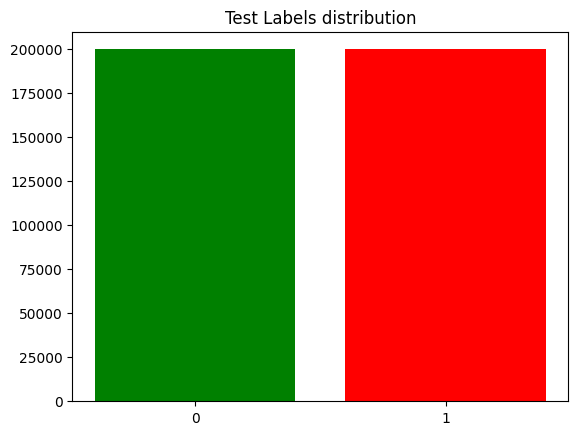

In [12]:
test_label_counts = Counter(test_labels)
print(test_label_counts)
plt.bar(test_label_counts.keys(),test_label_counts.values(),color=['red','green'])
plt.xticks([0,1])
plt.title('Test Labels distribution')
plt.show()

### Extracting Reviews from the data
clean newline character

In [13]:
train_sentences = [x.split(' ', 1)[1][:-1] for x in train_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1] for x in test_file_lines]

In [15]:
train_sentences[55]

'Good but received defective book: I bought this book because we are moving to Germany and I wanted to get a good overview of all the countries in Europe that we could travel too. Unfortunately pages 457-480 on Greece are not in English - looks to be Spanish. There was some sort of printing problem! But I found the rest of the book to give good highlights of the countries.'

In [17]:
train_sentences_size = list(map(lambda x: len(x.split()), train_sentences))
train_label_len = pd.DataFrame({"labels": train_labels, "len": train_sentences_size})
train_label_len.head()

,labels,len
0,1,80
1,1,97
2,1,129
3,1,118
4,1,87


Now we’ll divide it by sentiment and calculate average values

Negative mean length: 81.50
Positive mean length: 75.46
Mean Difference: 6.04


Text(0.5, 1.0, 'Review Size Categorization')

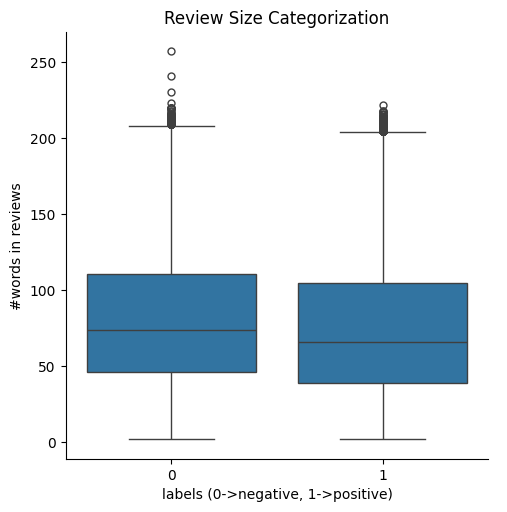

In [18]:
neg_mean_len = train_label_len.groupby('labels')['len'].mean().values[0]
pos_mean_len = train_label_len.groupby('labels')['len'].mean().values[1]

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")
sns.catplot(x='labels', y='len', data=train_label_len, kind='box')
plt.xlabel("labels (0->negative, 1->positive)")
plt.ylabel("#words in reviews")
plt.title("Review Size Categorization")

### Clean URLs
mask url in data with `<url>`

In [19]:
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])

for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [21]:
list(filter(lambda x: '<url>' in x, train_sentences))[5]

'See my article "Jean Hill - The Lady in Red" online: Since writing my review of JFK: THE LAST DISSENTING WITNESS in 1998, I have been able to have my 35-page article - "Jean Hill -The Lady in Red" - included in Clint Bradford\'s JFK Assassination website. The address is: <url> (scroll down for title).'

In [30]:
import nltk
from nltk import pos_tag
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

nltk.download('averaged_perceptron_tagger_eng')
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(text):
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(word_tokenize(text))]

lemmatize_sent('He is WALKING walking to school')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


['he', 'be', 'walking', 'walk', 'to', 'school']

## Stopwords and Punctuations



In [32]:
# Stopwords from stopwords-json
nltk.download('stopwords')
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
# Combine the stopwords. Its a lot longer so I'm not printing it out...
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Clean Digits

In [33]:
def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return [word for word in lemmatize_sent(text)
            if word not in stoplist_combined
            and not word.isdigit()]

In [36]:
train_sentences[12]

'Great Read: I thought this book was brilliant, but yet realistic. It showed me that to error is human. I loved the fact that this writer showed the loving side of God and not the revengeful side of him. I loved how it twisted and turned and I could not put it down. I also loved The glass castle.'

In [37]:
preprocess_text(train_sentences[12])

['great',
 'read',
 'book',
 'brilliant',
 'realistic',
 'show',
 'error',
 'human',
 'love',
 'fact',
 'writer',
 'show',
 'loving',
 'side',
 'god',
 'revengeful',
 'side',
 'love',
 'twist',
 'turn',
 'put',
 'love',
 'glass',
 'castle']

## Word Embeddings

#### We are using sklearn CountVectorizer to create Vector Space Model

## Vectorization with sklearn

In scikit-learn, there're pre-built functions to do the preprocessing and vectorization.  

It will be the object that contains the vocabulary (i.e. the first row of our table above) and has the function to convert any sentence into the counts vectors.  

The input that CountVectorizer is a textfile/Iterable of strings

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=preprocess_text)

In [79]:
with open('saved_models/vectorizer.pkl', 'wb') as file:
    pickle.dump(count_vect, file)

In [39]:
train_set = count_vect.fit_transform(train_sentences[:10000])

In [40]:
train_set.toarray().shape

(10000, 32658)

In [41]:
test_set = count_vect.transform(test_sentences[:1000])

<Axes: title={'center': 'Most Frequent Words'}, xlabel='word'>

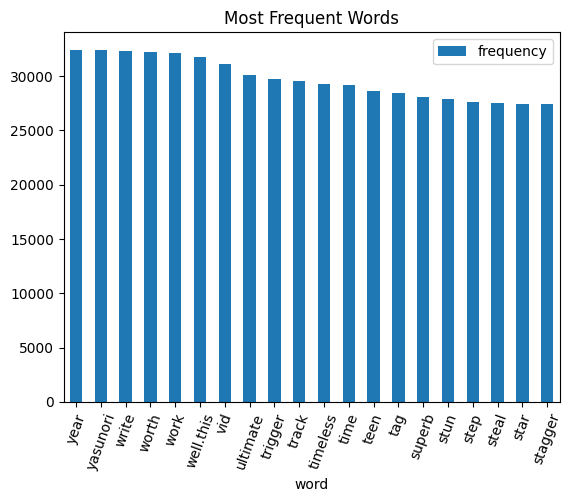

In [42]:
most_freq_words = pd.DataFrame(count_vect.vocabulary_.items(), columns=['word', 'frequency'])[:100].sort_values(ascending=False, by = "frequency")[:20]
most_freq_words.plot.bar(x="word", y="frequency", rot=70, title="Most Frequent Words")


## Multinomial Naive Bayes classifier in sklearn


In [57]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [58]:
clf.fit(train_set, train_labels[:10000])

MultinomialNB()

In [59]:
from sklearn.metrics import accuracy_score

# To predict our tags (i.e. whether requesters get their pizza),
# we feed the vectorized `test_set` to .predict()
predictions_valid = clf.predict(test_set)

print('Amazon Sentiment Analysis Accuracy = {}'.format(
        accuracy_score(predictions_valid, test_labels[:1000]) * 100)
     )

Amazon Sentiment Analysis Accuracy = 82.6


## Feature Importance

In [49]:
def important_features(vectorizer,classifier,n=40):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names_out()

    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]

    class1_frequency_dict = {}
    class2_frequency_dict = {}

    for coef, feat in topn_class1:
        class1_frequency_dict.update( {feat : coef} )

    for coef, feat in topn_class2:
        class2_frequency_dict.update( {feat : coef} )

    return (class1_frequency_dict, class2_frequency_dict)

In [50]:
neg_frequency_dict, pos_frequency_dict = important_features(count_vect, clf)

In [51]:
neg_feature_freq = pd.DataFrame(neg_frequency_dict.items(), columns = ["feature_word", "frequency"])
pos_feature_freq = pd.DataFrame(pos_frequency_dict.items(), columns = ["feature_word", "frequency"])

<Axes: title={'center': 'Important Negative Features(words)'}, xlabel='feature_word'>

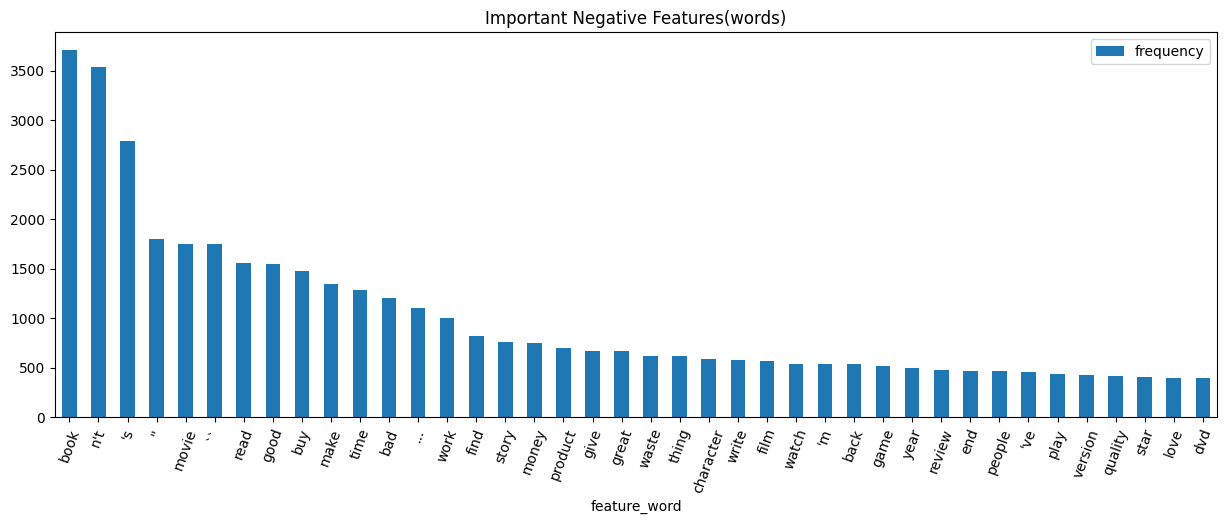

In [52]:
neg_feature_freq.plot.bar(x="feature_word", y="frequency", rot=70, figsize=(15, 5), title="Important Negative Features(words)")

<Axes: title={'center': 'Important Positive Features(words)'}, xlabel='feature_word'>

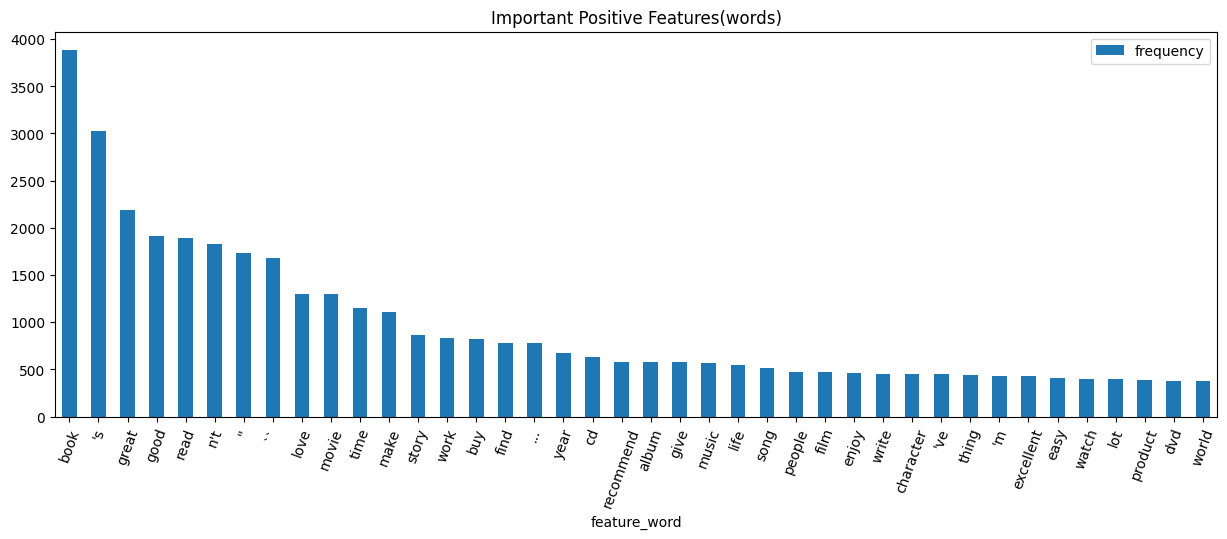

In [53]:
pos_feature_freq.plot.bar(x="feature_word", y="frequency", rot=70, figsize=(15, 5), title="Important Positive Features(words)")

Starting Model Comparison for Sentiment Analysis

Training Naive Bayes...
✓ Naive Bayes completed - Accuracy: 82.60%

Training SVM...
✓ SVM completed - Accuracy: 82.40%

Training Logistic Regression...
✓ Logistic Regression completed - Accuracy: 84.00%

Training Random Forest...
✓ Random Forest completed - Accuracy: 84.50%

MODEL COMPARISON RESULTS
              Model  Accuracy (%)  F1 Score  Precision  Recall  Training Time (s)  Prediction Time (s)
        Naive Bayes          82.6    0.8259     0.8272   0.826               0.01               0.0011
                SVM          82.4    0.8240     0.8240   0.824              19.41               1.1897
Logistic Regression          84.0    0.8400     0.8400   0.840               2.44               0.0005
      Random Forest          84.5    0.8450     0.8451   0.845              17.13               0.1146

Best Accuracy: Random Forest (84.5%)
Best F1 Score: Random Forest (0.845)

PERFORMANCE SUMMARY

Ranking by Accuracy:
1. Random Forest

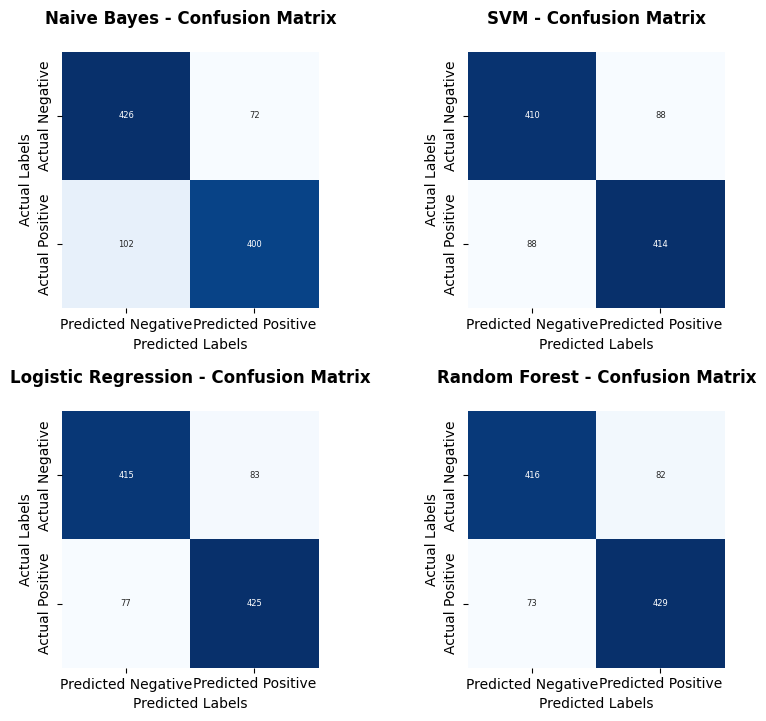

In [77]:

# Define models to test
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

# Initialize results storage
results = []
confusion_matrices = {}

print("Starting Model Comparison for Sentiment Analysis")
print("=" * 100)

# Loop through each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Record training time
    start_time = time.time()

    # Train the model on full training set
    model.fit(train_set, train_labels[:10000])

    with open(f'saved_models/{model_name}_model.pkl', 'wb') as f:
      pickle.dump(model, f)

    training_time = time.time() - start_time

    # Make predictions on full test set
    start_pred_time = time.time()
    predictions_valid = model.predict(test_set)
    prediction_time = time.time() - start_pred_time

    # Calculate metrics on full test set
    test_labels_subset = test_labels[:1000]

    accuracy = accuracy_score(test_labels_subset, predictions_valid)
    f1 = f1_score(test_labels_subset, predictions_valid, average='weighted')
    precision = precision_score(test_labels_subset, predictions_valid, average='weighted')
    recall = recall_score(test_labels_subset, predictions_valid, average='weighted')

    # Store confusion matrix
    cm = confusion_matrix(test_labels_subset, predictions_valid)
    confusion_matrices[model_name] = cm

    # Store results
    results.append({
        'Model': model_name,
        'Accuracy (%)': round(accuracy * 100, 2),
        'F1 Score': round(f1, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'Training Time (s)': round(training_time, 2),
        'Prediction Time (s)': round(prediction_time, 4)
    })

    print(f"✓ {model_name} completed - Accuracy: {accuracy*100:.2f}%")

# Create results DataFrame
results_df = pd.DataFrame(results)

# Display results table
print("\n" + "="*100)
print("MODEL COMPARISON RESULTS")
print("="*100)
print(results_df.to_string(index=False))

# Find best performing model
best_accuracy_idx = results_df['Accuracy (%)'].idxmax()
best_f1_idx = results_df['F1 Score'].idxmax()

print(f"\nBest Accuracy: {results_df.loc[best_accuracy_idx, 'Model']} ({results_df.loc[best_accuracy_idx, 'Accuracy (%)']}%)")
print(f"Best F1 Score: {results_df.loc[best_f1_idx, 'Model']} ({results_df.loc[best_f1_idx, 'F1 Score']})")


n_models = len(confusion_matrices)
cols = 2
rows = (n_models + 1) // 2

fig, axes = plt.subplots(rows, cols, figsize=(10, 4*rows))
if n_models == 1:
    axes = [axes]
elif rows == 1:
    axes = axes.reshape(1, -1)

# Flatten axes for easy iteration
axes_flat = axes.flatten()
for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
    ax = axes_flat[idx]

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'],
                ax=ax,cbar=False, square=True,
                annot_kws={'size': 6})

    ax.set_title(f'{model_name} - Confusion Matrix', fontsize=12, fontweight='bold', pad=20)
    ax.set_xlabel('Predicted Labels', fontsize=10)
    ax.set_ylabel('Actual Labels', fontsize=10)

plt.subplots_adjust(hspace=0.4, wspace=0.1)

# Create a summary visualization of results
print("\n" + "="*100)
print("PERFORMANCE SUMMARY")
print("="*100)

# Sort by accuracy for better visualization
sorted_results = results_df.sort_values('Accuracy (%)', ascending=False)

print("\nRanking by Accuracy:")
for i, (idx, row) in enumerate(sorted_results.iterrows(), 1):
    print(f"{i}. {row['Model']}: {row['Accuracy (%)']}% (F1: {row['F1 Score']}, Time: {row['Training Time (s)']}s)")
print("\n")



In [82]:
# Load vectorizer
with open('saved_models/vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

# Load model
with open('saved_models/Logistic Regression_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Example review
review = "I really loved this product! It works perfectly."

# Transform review using loaded vectorizer
review_vector = vectorizer.transform([review])

# Predict sentiment
prediction = model.predict(review_vector)
print("Predicted sentiment:", prediction[0])


Predicted sentiment: 1


In [85]:
import ipywidgets as widgets
from IPython.display import display

# List of your saved model files
model_files = ['saved_models/Logistic Regression_model.pkl', 'saved_models/Naive Bayes_model.pkl','saved_models/SVM_model.pkl','saved_models/Random Forest_model.pkl']

# Dropdown widget for model selection
model_dropdown = widgets.Dropdown(
    options=model_files,
    description='Choose model:',
    disabled=False
)

# Text input widget for review
review_input = widgets.Text(
    value='',
    placeholder='Type your review here',
    description='Review:',
    layout=widgets.Layout(width='80%')
)

# Button to trigger prediction
predict_button = widgets.Button(description="Predict Sentiment")

# Output widget to display results
output = widgets.Output()

def preprocess_review(text):
    # If your vectorizer uses a custom preprocessing function,
    # ensure it is loaded or defined before prediction
    return text

def predict_sentiment(b):
    output.clear_output()

    # Load selected model
    with open(model_dropdown.value, 'rb') as file:
        model = pickle.load(file)

    # Load vectorizer
    vectorizer_file = 'saved_models/vectorizer.pkl'
    with open(vectorizer_file, 'rb') as file:
        vectorizer = pickle.load(file)

    # Transform review
    review_vector = vectorizer.transform([review_input.value])

    # Predict
    prediction = model.predict(review_vector)[0]

    # Optional: probability
    prob = model.predict_proba(review_vector)[0] if hasattr(model, 'predict_proba') else None

    with output:
        print(f"Predicted sentiment: {prediction}")
        if prob is not None:
            print(f"Probability: {prob}")

# Connect button click to function
predict_button.on_click(predict_sentiment)

# Display widgets
display(model_dropdown, review_input, predict_button, output)

Dropdown(description='Choose model:', options=('saved_models/Logistic Regression_model.pkl', 'saved_models/Nai…

Text(value='', description='Review:', layout=Layout(width='80%'), placeholder='Type your review here')

Button(description='Predict Sentiment', style=ButtonStyle())

Output()